# 🚕 Uber Trip Analysis - (NYC 2014)

This project analyzes and forecasts Uber trip demand in New York City using 2014 data.  
We'll perform the following steps:

1. Load and preprocess the data  
2. Explore trip patterns  
3. Build models to forecast trip demand  
4. Evaluate model performance


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [2]:
files = glob.glob("../data/uber-raw-data-*.csv")
print("Found files:", files)

dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)
print("Combined shape:", df.shape)

Found files: ['../data\\uber-raw-data-apr14.csv', '../data\\uber-raw-data-aug14.csv', '../data\\uber-raw-data-jul14.csv', '../data\\uber-raw-data-jun14.csv', '../data\\uber-raw-data-may14.csv', '../data\\uber-raw-data-sep14.csv']
Combined shape: (4534327, 4)


In [3]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Hour'] = df['Date/Time'].dt.hour
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek
df['Date'] = df['Date/Time'].dt.floor('H')
hourly_trips = df.groupby('Date').size().reset_index(name='Count')
hourly_trips.set_index('Date', inplace=True)
hourly_trips.head()

,Count
Date,
2014-04-01 00:00:00,138
2014-04-01 01:00:00,66
2014-04-01 02:00:00,53
2014-04-01 03:00:00,93
2014-04-01 04:00:00,166


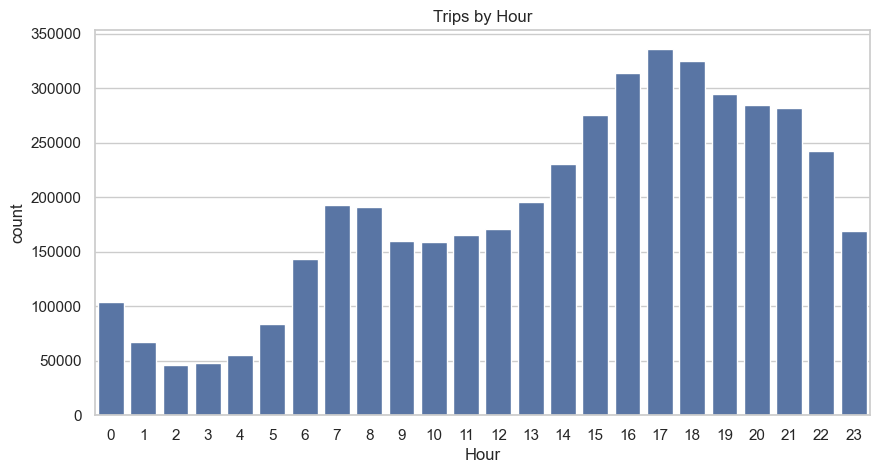

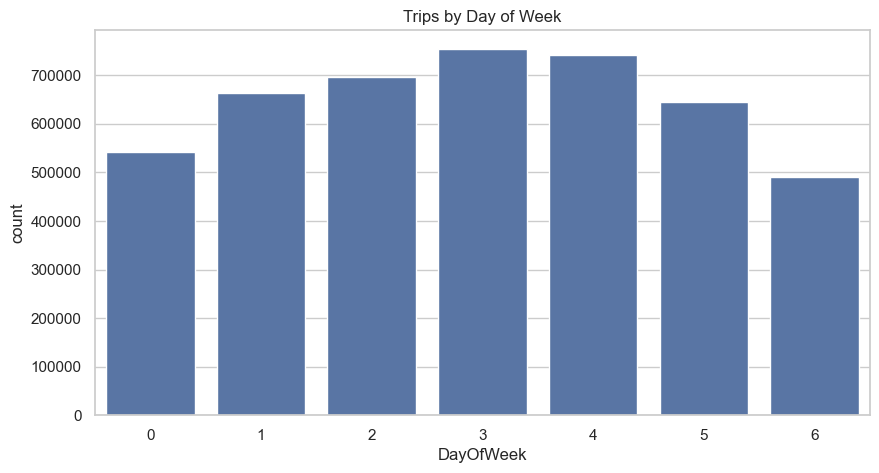

In [4]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Hour', data=df)
plt.title("Trips by Hour")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='DayOfWeek', data=df)
plt.title("Trips by Day of Week")
plt.show()

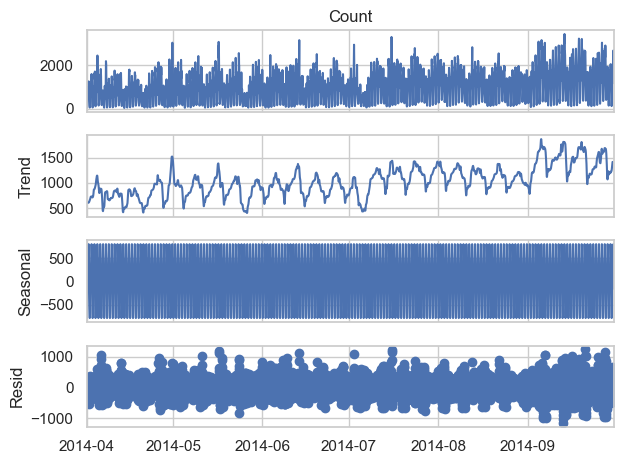

In [5]:
result = seasonal_decompose(hourly_trips['Count'], model='additive', period=24)
result.plot()
plt.show()

In [6]:
train = hourly_trips.loc[:'2014-09-15']
test = hourly_trips.loc['2014-09-16':]

def create_lagged_features(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

window = 24
X_train, y_train = create_lagged_features(train['Count'].values, window)
test_data = np.concatenate([train['Count'].values[-window:], test['Count'].values])
X_test, y_test = create_lagged_features(test_data, window)

In [7]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

gbr = GradientBoostingRegressor(n_estimators=300)
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)

In [8]:
xgb_mape = mean_absolute_percentage_error(y_test, xgb_preds)
rf_mape = mean_absolute_percentage_error(y_test, rf_preds)
gbr_mape = mean_absolute_percentage_error(y_test, gbr_preds)

print(f"XGBoost MAPE: {xgb_mape:.2%}")
print(f"Random Forest MAPE: {rf_mape:.2%}")
print(f"Gradient Boosting MAPE: {gbr_mape:.2%}")

XGBoost MAPE: 9.28%
Random Forest MAPE: 8.88%
Gradient Boosting MAPE: 10.61%


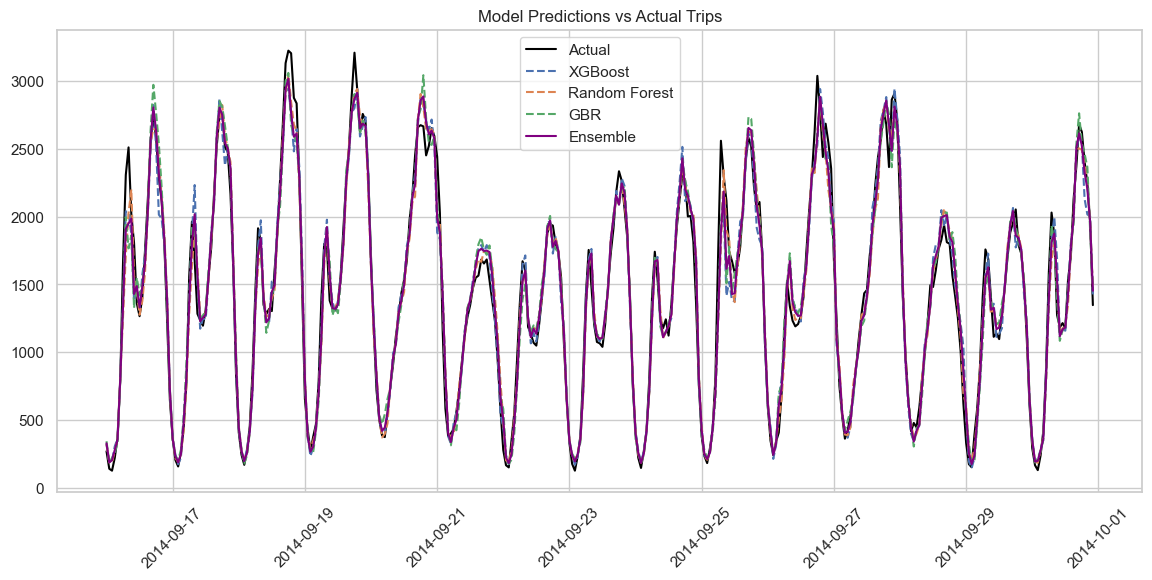

In [9]:
weights = np.array([1/xgb_mape, 1/rf_mape, 1/gbr_mape])
weights /= weights.sum()
ensemble_preds = weights[0]*xgb_preds + weights[1]*rf_preds + weights[2]*gbr_preds

plt.figure(figsize=(14,6))
plt.plot(test.index[:len(y_test)], y_test, label="Actual", color="black")
plt.plot(test.index[:len(xgb_preds)], xgb_preds, label="XGBoost", linestyle="--")
plt.plot(test.index[:len(rf_preds)], rf_preds, label="Random Forest", linestyle="--")
plt.plot(test.index[:len(gbr_preds)], gbr_preds, label="GBR", linestyle="--")
plt.plot(test.index[:len(ensemble_preds)], ensemble_preds, label="Ensemble", color="purple")
plt.legend()
plt.title("Model Predictions vs Actual Trips")
plt.xticks(rotation=45)
plt.show()